# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

In [1]:
import math
import os
import pickle

from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import umap.plot

from sklearn.manifold import TSNE

from ConstantsUtil import ConstantsUtil
from ClassificationUtil import ClassificationUtil

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

pd.options.mode.chained_assignment = None

In [3]:
constants = ConstantsUtil()
util = ClassificationUtil(complete_embeddings_dir = constants.COMPLETE_EMBEDDINGS)

<hr>

In [4]:
boeckaerts = pd.read_csv(f'{constants.INPHARED}/{constants.DATA}/{constants.PLM_EMBEDDINGS_CSV["BOECKAERTS"]}', 
                         low_memory = False)
prott5 = pd.read_csv(f'{constants.INPHARED}/{constants.DATA}/{constants.PLM_EMBEDDINGS_CSV["PROTT5"]}',
                     low_memory = False)

rbp_embeddings = pd.merge(boeckaerts, prott5, how = 'inner', validate = 'one_to_one')
rbp_embeddings.head()

,Protein ID,Accession,Description,Classification,Genome Length (bp),Jumbophage,molGC (%),Molecule,Modification Date,Number CDS,Positive Strand (%),Negative Strand (%),Coding Capacity(%),Low Coding Capacity Warning,tRNAs,Host,Lowest Taxa,Genus,Sub-family,Family,Order,Class,Phylum,Kingdom,Realm,...,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,BAF36105.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,34.391534,65.608466,93.542616,NaN,2,microcystis,Fukuivirus,Fukuivirus,Unclassified,Unclassified,Unclassified,Caudoviricetes,Uroviricota,Heunggongvirae,Duplodnaviria,...,-0.076231,-0.032696,-0.001955,0.000653,0.054578,0.108078,0.037636,-0.002578,0.024490,-0.008848,0.007777,-0.039980,-0.060010,0.048280,-0.001459,-0.024003,-0.029409,0.013041,-0.025576,0.000868,0.053601,0.028784,-0.014681,0.029822,-0.063528
1,BAF36110.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,34.391534,65.608466,93.542616,NaN,2,microcystis,Fukuivirus,Fukuivirus,Unclassified,Unclassified,Unclassified,Caudoviricetes,Uroviricota,Heunggongvirae,Duplodnaviria,...,-0.041830,0.014031,0.001425,-0.014960,0.016504,0.110198,0.066803,-0.037050,0.017452,0.038544,-0.040069,-0.079425,-0.138132,0.070560,0.005162,-0.061395,0.019466,0.023357,-0.049386,0.012918,0.052622,0.025504,0.011063,0.043035,0.057878
2,BAF36131.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,34.391534,65.608466,93.542616,NaN,2,microcystis,Fukuivirus,Fukuivirus,Unclassified,Unclassified,Unclassified,Caudoviricetes,Uroviricota,Heunggongvirae,Duplodnaviria,...,-0.021261,0.036598,0.026375,-0.028394,0.065118,0.130821,0.028742,-0.039870,0.039776,0.085752,0.037337,-0.088677,-0.055613,-0.015769,-0.033975,-0.050904,-0.006077,0.025978,-0.019343,-0.008771,0.047186,0.048965,-0.010241,0.038061,-0.004695
3,BAF36132.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,34.391534,65.608466,93.542616,NaN,2,microcystis,Fukuivirus,Fukuivirus,Unclassified,Unclassified,Unclassified,Caudoviricetes,Uroviricota,Heunggongvirae,Duplodnaviria,...,-0.021080,-0.006112,-0.039357,-0.012591,0.032461,0.112405,0.026059,-0.041831,0.023897,0.097193,0.025826,-0.054745,-0.119837,-0.000103,0.001374,-0.052231,-0.007240,-0.034144,-0.084727,0.018650,0.052715,0.021225,0.021085,0.053816,-0.011411
4,BAF36193.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,34.391534,65.608466,93.542616,NaN,2,microcystis,Fukuivirus,Fukuivirus,Unclassified,Unclassified,Unclassified,Caudoviricetes,Uroviricota,Heunggongvirae,Duplodnaviria,...,-0.096319,-0.002854,-0.033014,0.037848,-0.005358,0.089434,0.057299,-0.077981,-0.000817,-0.030628,0.021488,-0.058278,-0.100803,0.011171,-0.052968,0.028329,-0.019079,0.018484,0.006488,0.022265,0.029314,-0.009222,0.017038,0.040056,0.018588


In [5]:
with open(constants.FEATURE_IMPORTANCE, 'rb') as f:
    feat_impt = pickle.load(f)
    feat_impt2 = []
    for i in feat_impt:
        feat_impt2.append(str(i).strip())
        
SIZE = 100
feat_cols = feat_impt2[:SIZE]

In [6]:
interval1 = ''
interval2 = ''
interval3 = ''

def group(x):    
    delta = (rbp_embeddings[attr].max() - rbp_embeddings[attr].min()) / 3
    group1 = rbp_embeddings[attr].min() + delta
    group2 = group1 + delta

    global interval1, interval2, interval3
    interval1 = '[' + '{:.2f}'.format(rbp_embeddings[attr].min()) + ', ' + '{:.2f}'.format(group1) + ')'
    interval2 = '[' + '{:.2f}'.format(group1) + ', ' + '{:.2f}'.format(group2) + ')'
    interval3 = '[' + '{:.2f}'.format(group2) + ', ' + '{:.2f}'.format(rbp_embeddings[attr].max()) + ']'
    
    if attr == 'GC':
        interval1 = '[' + '{:.2f}'.format(rbp_embeddings[attr].min() / 100) + ', ' + '{:.2f}'.format(group1 / 100) + ')'
        interval2 = '[' + '{:.2f}'.format(group1 / 100) + ', ' + '{:.2f}'.format(group2 / 100) + ')'
        interval3 = '[' + '{:.2f}'.format(group2 / 100) + ', ' + '{:.2f}'.format(rbp_embeddings[attr].max() / 100) + ']'

    if x < group1:
        return 1
    
    if x < group2:
        return 2
    
    return 3

In [7]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.dpi'] = 300

def draw_plot(map_results, title='', loc = 'upper right', s = 3):
    fig = plt.figure(figsize = (10, 10))
    result = plt.scatter(map_results[:,0], map_results[:,1], c = rbp_embeddings[attr + ' Group'].values, 
                         s = s, cmap = 'viridis')
    
    plt.legend(handles = result.legend_elements()[0], title = title, labels = [interval1, interval2, interval3], loc = loc,
               borderpad = 0.5, labelspacing = 0.5, handlelength = 0.25, handletextpad = 0.5)
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

<hr>

In [8]:
tsne = TSNE(n_components = 2, perplexity = 50, n_iter = 1000, init = 'pca', learning_rate='auto',
            random_state = util.RANDOM_NUM)
tsne_results = tsne.fit_transform(rbp_embeddings[feat_cols].values)

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


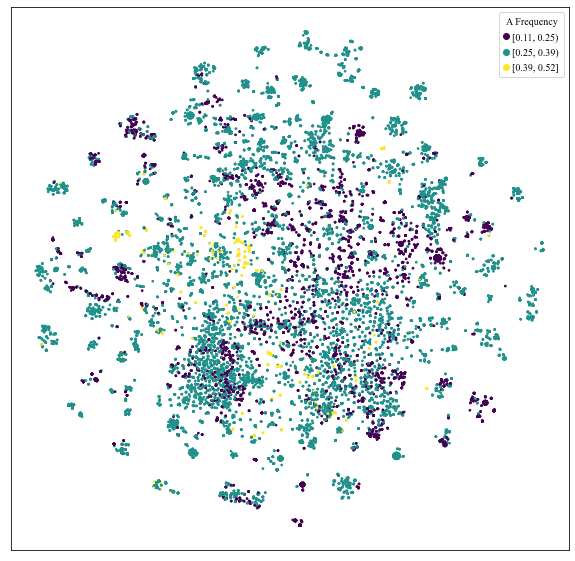

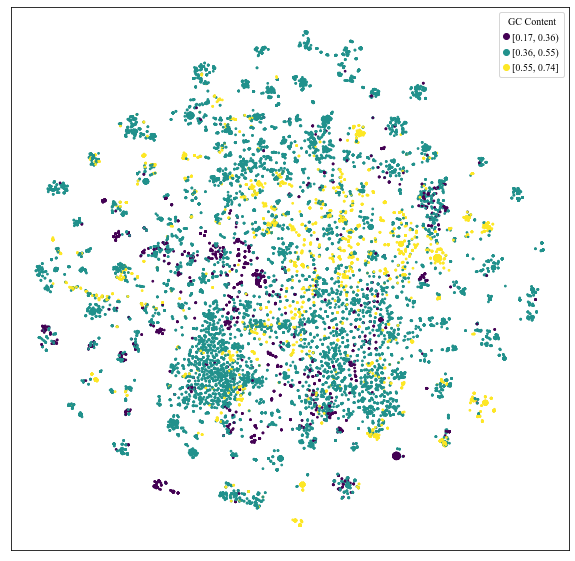

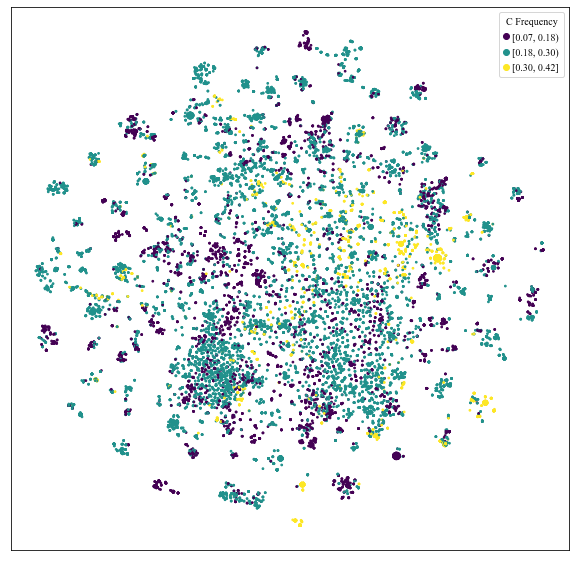

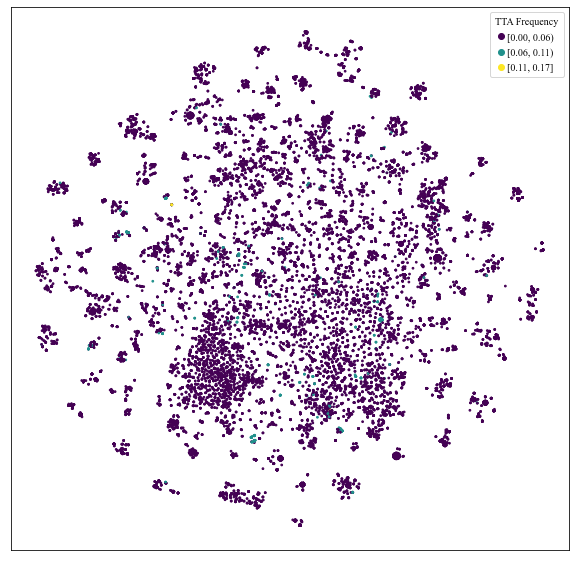

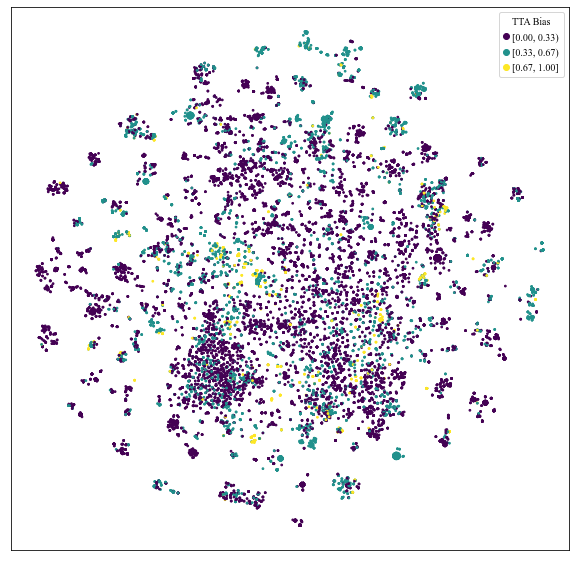

In [9]:
attrs = ['A_freq', 'GC', 'C_freq', 'TTA', 'TTA_b']
full_attrs = ['A Frequency', 'GC Content', 'C Frequency', 'TTA Frequency', 'TTA Bias']

for attr, full_attr in zip(attrs, full_attrs):
    rbp_embeddings[attr + ' Group'] = rbp_embeddings.apply(lambda x: group(x[attr]), axis = 1)
    draw_plot(tsne_results, full_attr)

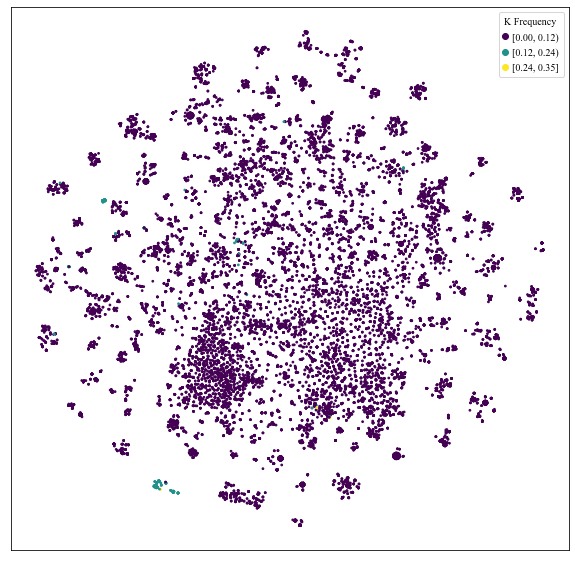

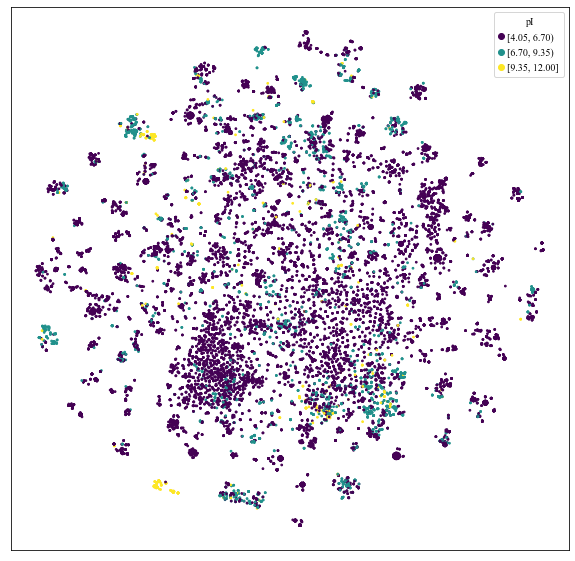

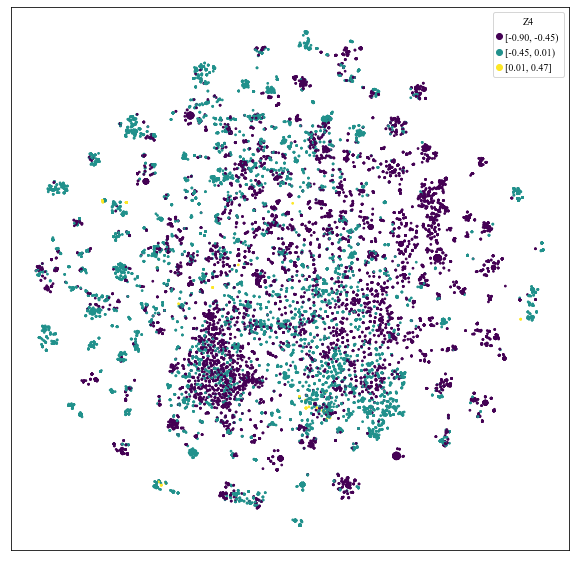

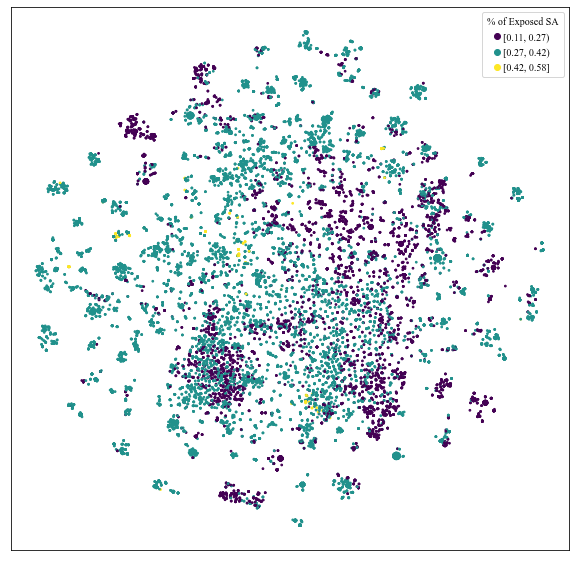

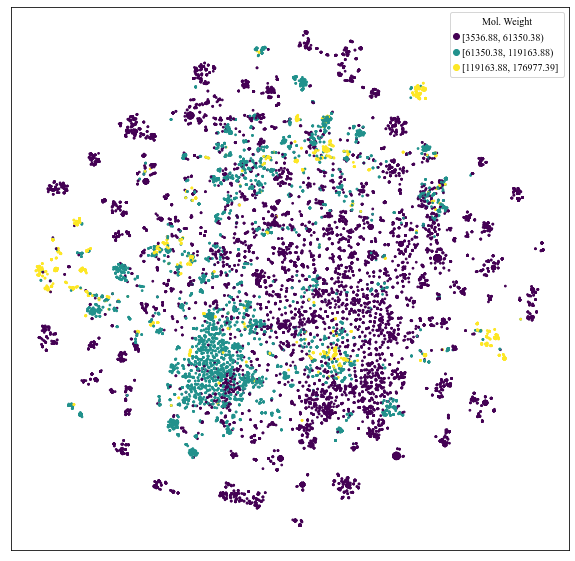

In [10]:
attrs = ['K', 'pI', 'Z4', 'CTDC2', 'mol_weight']
full_attrs = ['K Frequency ', 'pI', 'Z4', '% of Exposed SA', 'Mol. Weight']

for attr, full_attr in zip(attrs, full_attrs):
    rbp_embeddings[attr + ' Group'] = rbp_embeddings.apply(lambda x: group(x[attr]), axis = 1)
    draw_plot(tsne_results, full_attr)

<hr>

In [11]:
mapper = umap.UMAP(n_neighbors = 100, min_dist = 0.7, n_components = 2, 
                   random_state = util.RANDOM_NUM).fit_transform(rbp_embeddings[feat_cols].values)

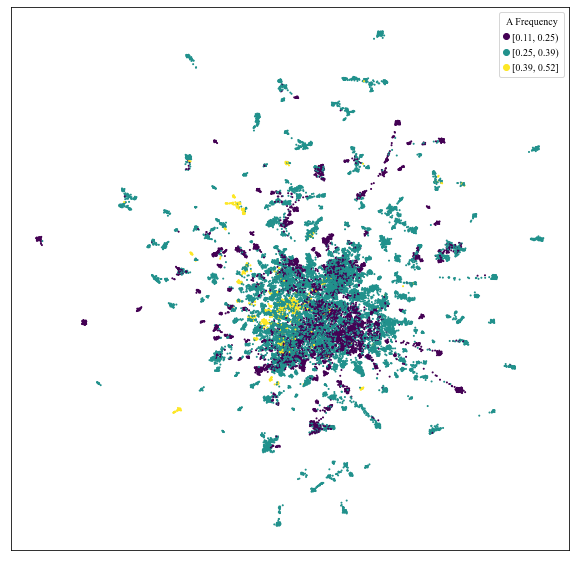

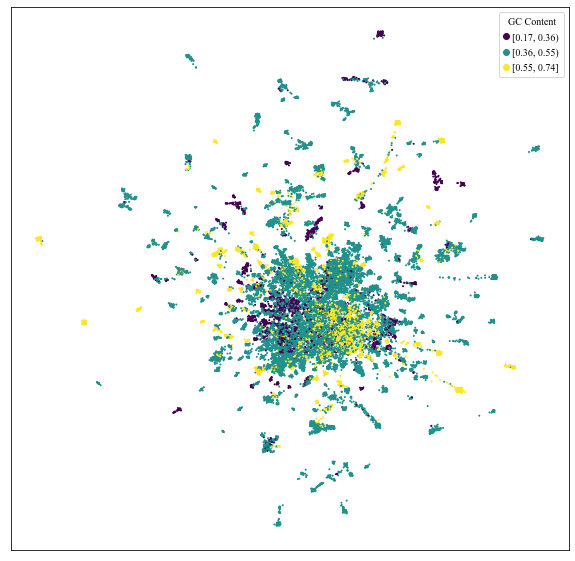

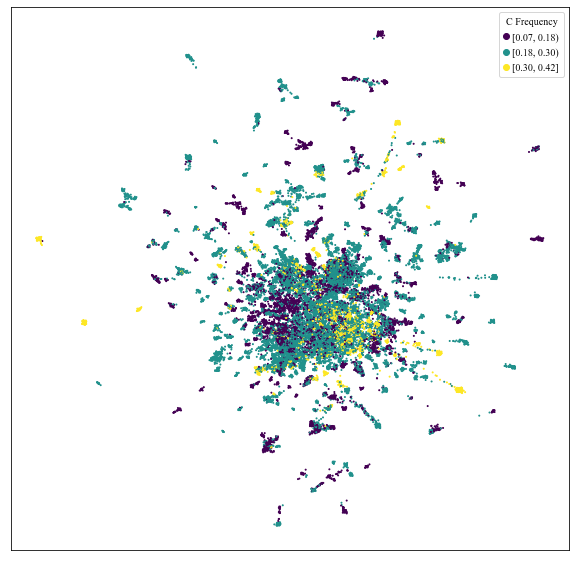

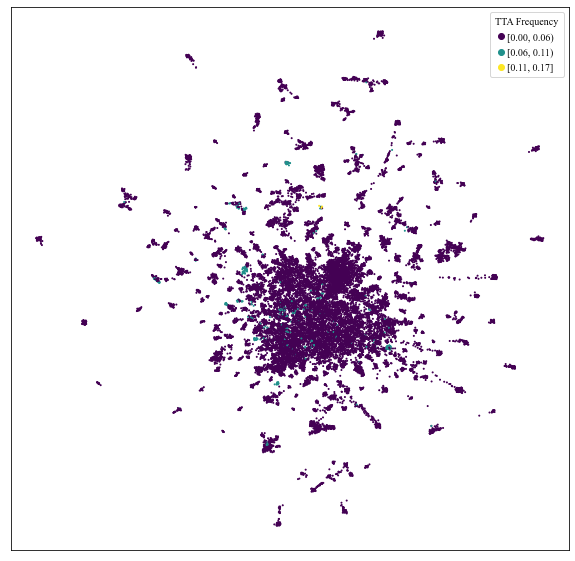

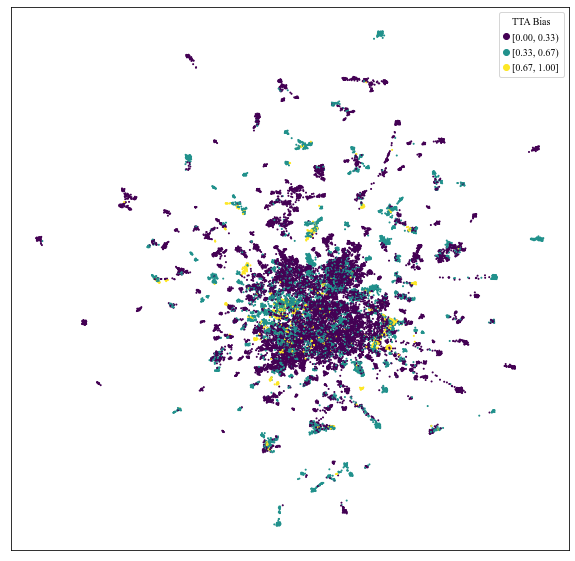

In [12]:
attrs = ['A_freq', 'GC', 'C_freq', 'TTA', 'TTA_b']
full_attrs = ['A Frequency', 'GC Content', 'C Frequency', 'TTA Frequency', 'TTA Bias']

for attr, full_attr in zip(attrs, full_attrs):
    rbp_embeddings[attr + ' Group'] = rbp_embeddings.apply(lambda x: group(x[attr]), axis = 1)
    draw_plot(mapper, full_attr, s = 1)

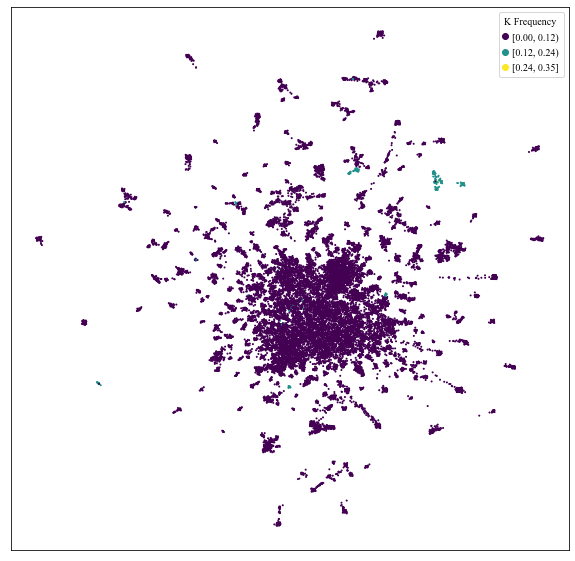

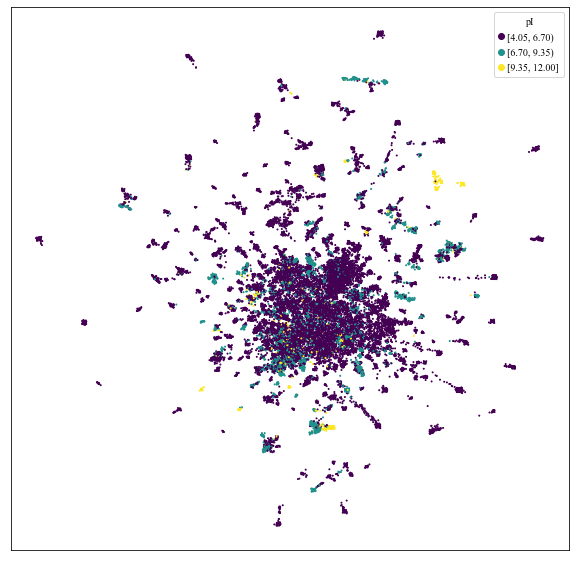

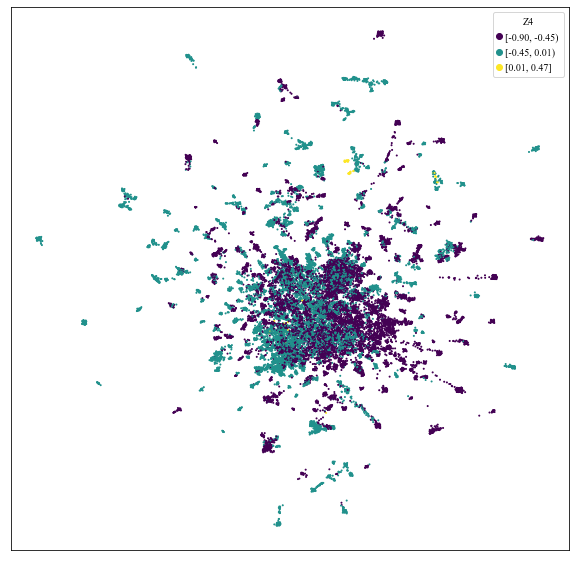

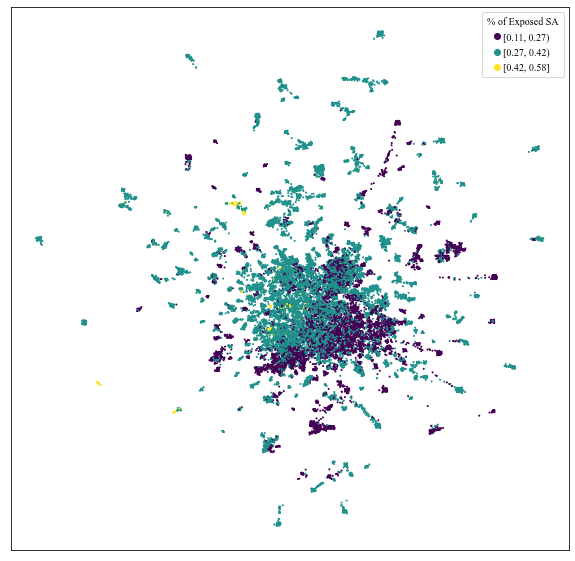

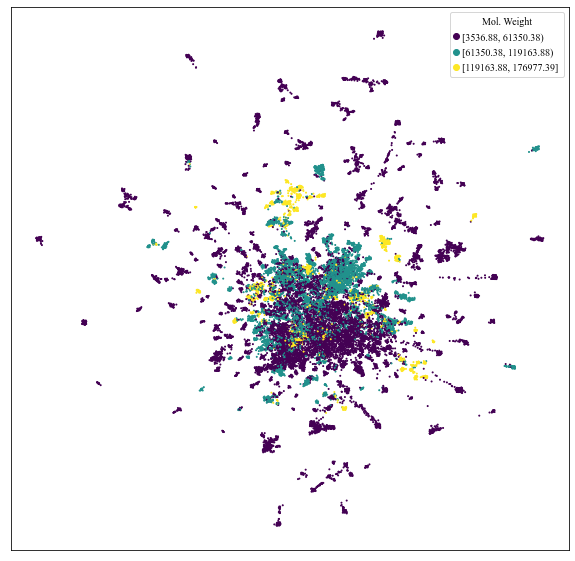

In [13]:
attrs = ['K', 'pI', 'Z4', 'CTDC2', 'mol_weight']
full_attrs = ['K Frequency ', 'pI', 'Z4', '% of Exposed SA', 'Mol. Weight']

for attr, full_attr in zip(attrs, full_attrs):
    rbp_embeddings[attr + ' Group'] = rbp_embeddings.apply(lambda x: group(x[attr]), axis = 1)
    draw_plot(mapper, full_attr, s = 1)